In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import random
import time

import pennylane as qml
from qiskit.quantum_info import Statevector
import tensorflow as tf

%matplotlib inline
plt.rcParams['figure.figsize'] = (5, 4)

# Loading Data

In [2]:
image_width = 4
numbers = [3, 6]
label_mapping = {numbers[0]: -1, numbers[1]: 1}
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

def filter_01(x, y):
    keep = (y == numbers[0]) | (y == numbers[1])
    x, y = x[keep], y[keep]
    return x, y

x_train, y_train = filter_01(x_train, y_train)
x_test, y_test = filter_01(x_test, y_test)

# compress images to (11,11) size
images_train0 = tf.image.resize(x_train, (image_width,image_width)).numpy()
images_test0 = tf.image.resize(x_test, (image_width,image_width)).numpy()

# squeeze the third dimention of every image
images_train1 = [np.squeeze(image) for image in images_train0]
images_test1 = [np.squeeze(image) for image in images_test0]

# reshaping images from (11,11) to (121, 1)
images_train_whole = [np.reshape(image, (image_width**2,1)) for image in images_train1]
labels_train_whole = [label_mapping.get(label, label) for label in list(y_train)]
num_training_samples_whole = len(images_train_whole)

images_test = [np.reshape(image, (image_width**2,1)) for image in images_test1]
labels_test = [label_mapping.get(label, label) for label in list(y_test)]
num_testing_samples = len(images_test)

def word_label(label):
    return {-1: f'{numbers[0]}', 1: f'{numbers[1]}'}.get(label, None)

print(f"Initially, there are {num_training_samples_whole} training samples")
print(f"Initially, there are {num_testing_samples} testing samples")

Initially, there are 12049 training samples
Initially, there are 1968 testing samples


### Choosing 1000 Images out of 12049

In [3]:
N = 1000
np.random.seed(40)
indices = random.sample(range(len(images_train_whole)), N)
images_train = [images_train_whole[i] for i in indices]
labels_train = [labels_train_whole[i] for i in indices]
num_training_samples = len(images_train)
print(f"Now, there are {num_training_samples} training samples")

Now, there are 1000 training samples


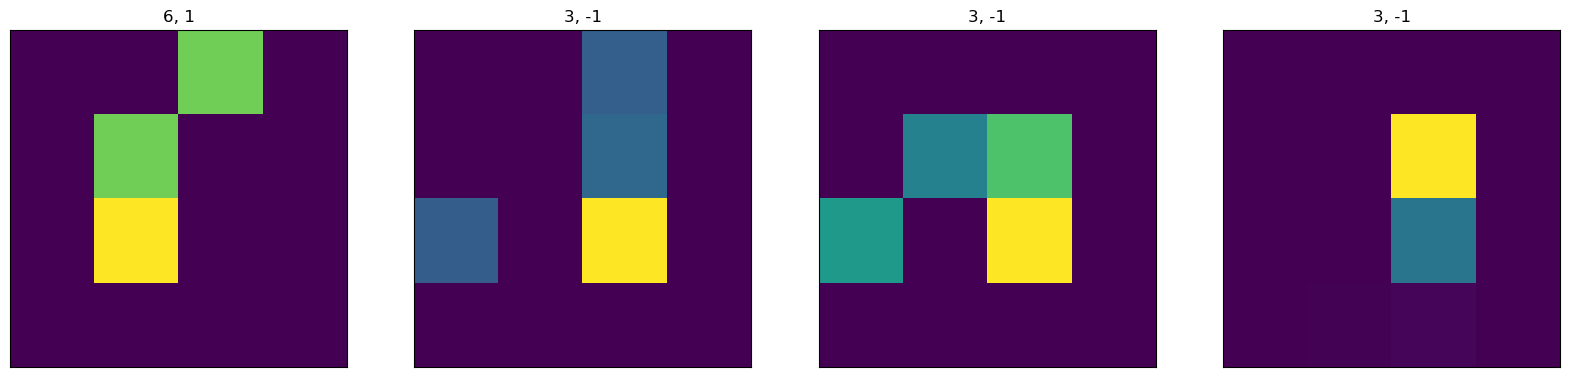

In [4]:
# showing the first four images
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i in range(4):
    axs[i].imshow(np.array(images_train[i]).reshape(4, 4))
    axs[i].set_title(f'{word_label(labels_train[i])}, {labels_train[i]}')
    axs[i].set_yticks([])
    axs[i].set_xticks([])

# Angle Encoding

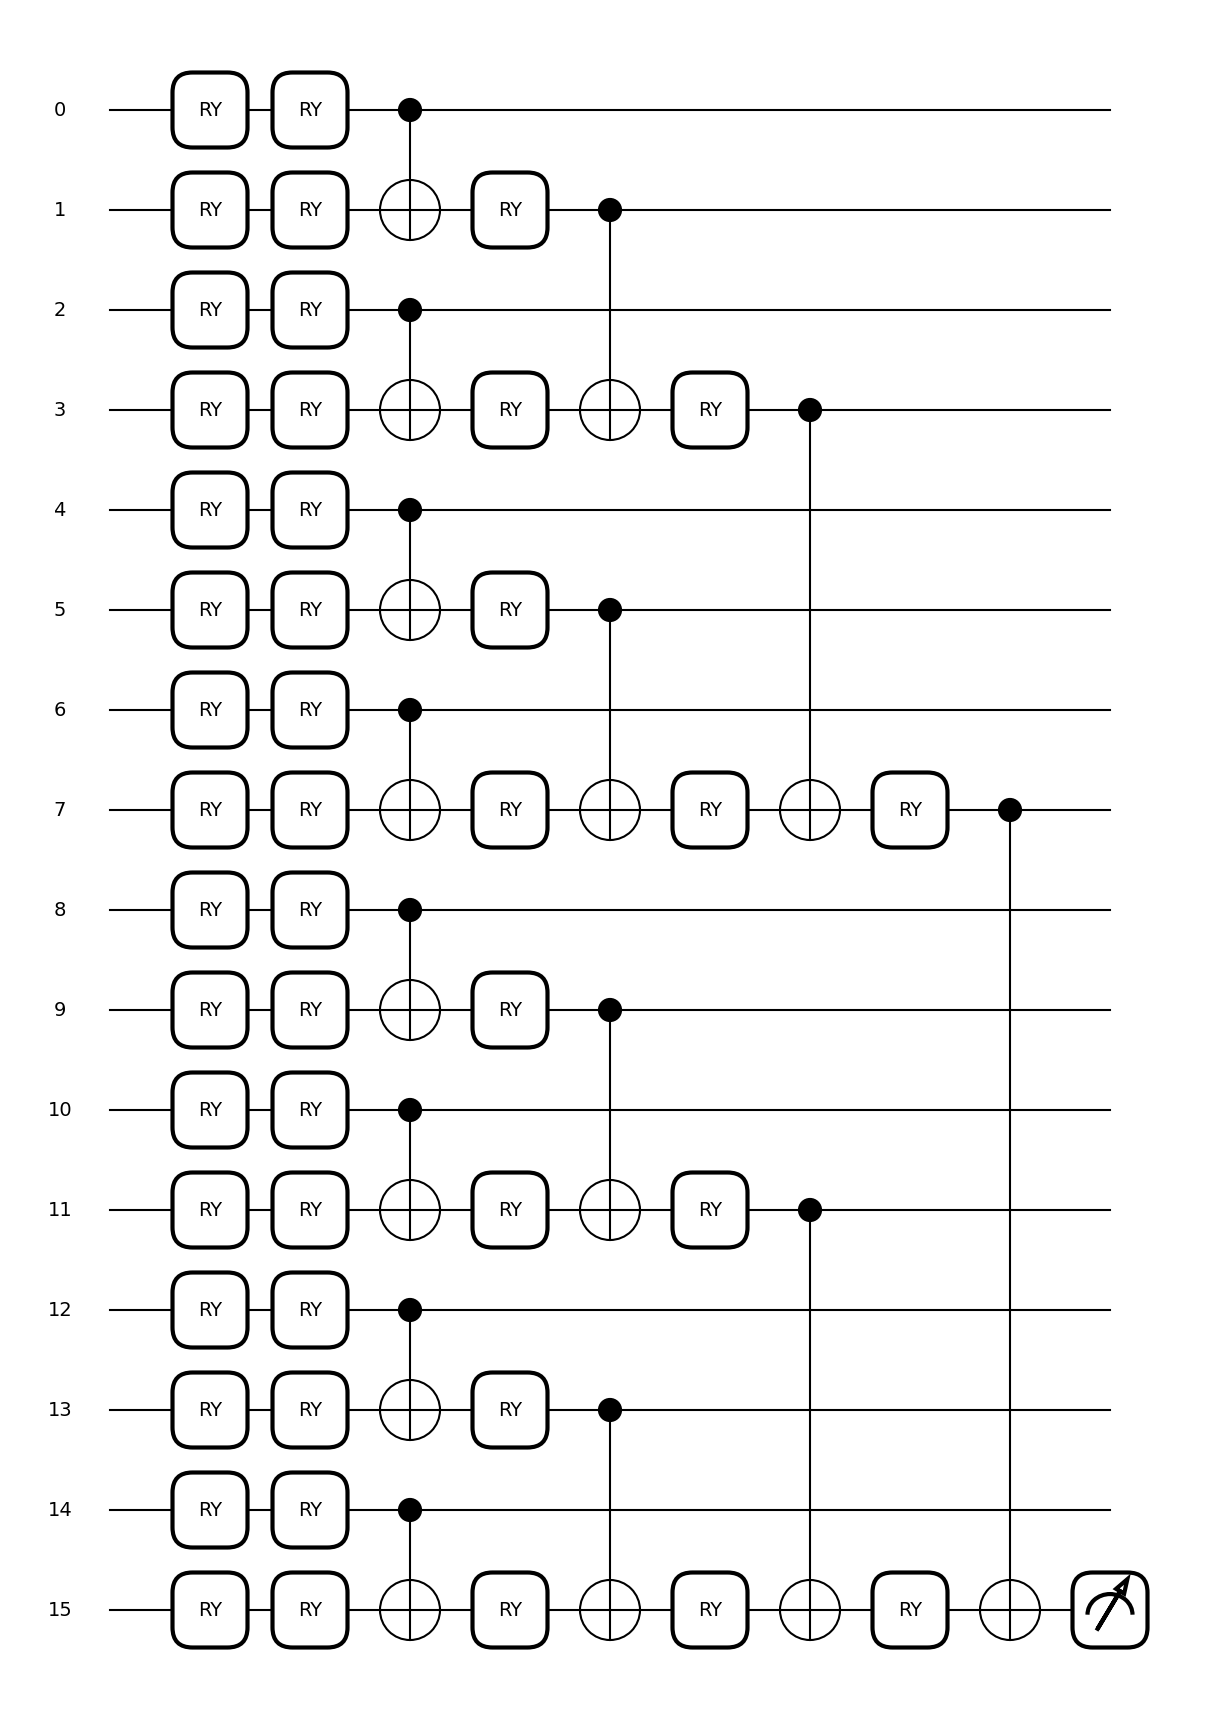

In [37]:
def ang_state_prep(image):
    for i, intensity in enumerate(image):
        qml.RY(intensity*np.pi, wires=[i])

def qfilter1(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.CNOT(wires=wires)
    
dev = qml.device("lightning.qubit", wires=16) # lightning for faster work

@qml.qnode(dev, interface="autograd")
def ang_circuit(image, weights):
    ang_state_prep(image)
    
    qfilter1(weights[0:2], wires=[0,1])
    qfilter1(weights[2:4], wires=[2,3])
    qfilter1(weights[4:6], wires=[4,5])
    qfilter1(weights[6:8], wires=[6,7])
    qfilter1(weights[8:10], wires=[8,9])
    qfilter1(weights[10:12], wires=[10,11])
    qfilter1(weights[12:14], wires=[12,13])
    qfilter1(weights[14:16], wires=[14,15])
    
    qfilter1(weights[16:18], wires=[1,3])
    qfilter1(weights[18:20], wires=[5,7])
    qfilter1(weights[20:22], wires=[9,11])
    qfilter1(weights[22:24], wires=[13,15])
    
    qfilter1(weights[24:26], wires=[3,7])
    qfilter1(weights[26:28], wires=[11,15])
    
    qfilter1(weights[28:30], wires=[7,15])
    
    observable = qml.PauliZ(15)
    return qml.expval(observable)

np.random.seed(42)
weights = np.random.random(size=(30,1))
image_index = 1
fig, ax = qml.draw_mpl(ang_circuit, expansion_strategy=None, decimals=2)(images_train[image_index], weights)

### Training Loop

In [68]:
def objective(weights):
    obj = 0
    for i, image in enumerate(images_train):
        prediction = ang_circuit(image, weights)
        if labels_train[i] == -1:
            obj += prediction
        if labels_train[i] == 1:
            obj -= prediction
    return obj

In [100]:
np.random.seed(42)
ang_params = np.random.random(size=[30, 1], requires_grad=True)
params_evol = [ang_params]
optimizer = qml.GradientDescentOptimizer(stepsize=0.001)
start_time = time.time()
err = []
num_steps = 50
for k in range(num_steps):
    step = optimizer.step_and_cost(objective, ang_params)
    err.append(step[1])
    if k % 1 == 0:
        print(f"Step {k}, cost: {step[1]}")
    ang_params = step[0]
    params_evol.append(ang_params)
end_time = time.time()
print(f'{end_time-start_time}s')

Step 0, cost: -4.400435042379682
Step 1, cost: -8.777588609617549
Step 2, cost: -14.141238232203003
Step 3, cost: -21.246690401253403
Step 4, cost: -31.113511972663503
Step 5, cost: -45.179656521146185
Step 6, cost: -65.43025685345846
Step 7, cost: -94.35560160266033
Step 8, cost: -134.43240145477796
Step 9, cost: -186.8396876832385
Step 10, cost: -249.751995172014
Step 11, cost: -317.35165069194943
Step 12, cost: -380.51211264868226
Step 13, cost: -430.4228028626692
Step 14, cost: -464.1176432213677
Step 15, cost: -484.8849743768336
Step 16, cost: -497.5379242231735
Step 17, cost: -505.51428890130614
Step 18, cost: -510.76297138785566
Step 19, cost: -514.33749436083
Step 20, cost: -516.8303181281684
Step 21, cost: -518.5977050612864
Step 22, cost: -519.8669409861154
Step 23, cost: -520.7890055001453
Step 24, cost: -521.4666891710382
Step 25, cost: -521.9710243170773
Step 26, cost: -522.3515808111044
Step 27, cost: -522.6432085654264
Step 28, cost: -522.8705659650432
Step 29, cost: -52

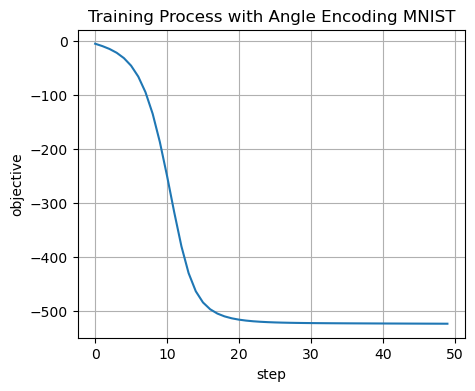

In [145]:
plt.plot(err, '-')
plt.xlabel('step')
plt.ylabel('objective')
plt.title('Training Process with Angle Encoding MNIST')
plt.grid()

In [11]:
def metrics(images, labels, circuit, params):
    accuracy, TP, FP, TN, FN = 0, 0, 0, 0, 0
    num_data_points = len(images)
    for i, image in enumerate(images):
        prediction = circuit(image, params)
        if np.sign(labels[i]*prediction) == 1:
            accuracy += 1
        if prediction > 0 and labels[i] > 0:
            TP += 1
        if prediction > 0 and labels[i] < 0:
            FP += 1
        if prediction < 0 and labels[i] < 0:
            TN += 1
        if prediction < 0 and labels[i] > 0:
            FN += 1
    accuracy = accuracy/num_data_points
    precision = TP/(TP+FP)
    recall = TP/(TP+FN)
    F1 = 2*precision*recall/(precision+recall)
    return accuracy, F1, precision, recall

In [149]:
ang_performance_train = metrics(images_train, labels_train, ang_circuit, ang_params)
ang_performance_test = metrics(images_test, labels_test, ang_circuit, ang_params)
print(f"Accuracy, F1, Precision, Recall on training images: {[round(m, 3) for m in ang_performance_train]}")
print(f"Accuracy, F1, Precision, Recall on testing images:  {[round(m, 3) for m in ang_performance_test]}")

Accuracy, F1, Precision, Recall on training images: [0.803, 0.829, 0.737, 0.949]
Accuracy, F1, Precision, Recall on testing images:  [0.78, 0.803, 0.714, 0.916]


In [150]:
ang_performance_train_whole = metrics(images_train_whole, labels_train_whole, ang_circuit, ang_params)
print(f"Accuracy, F1, Precision, Recall on the whole training set: {[round(m, 3) for m in ang_performance_train_whole]}")

Accuracy, F1, Precision, Recall on the whole training set: [0.777, 0.803, 0.709, 0.926]


# Amplitude Encoding

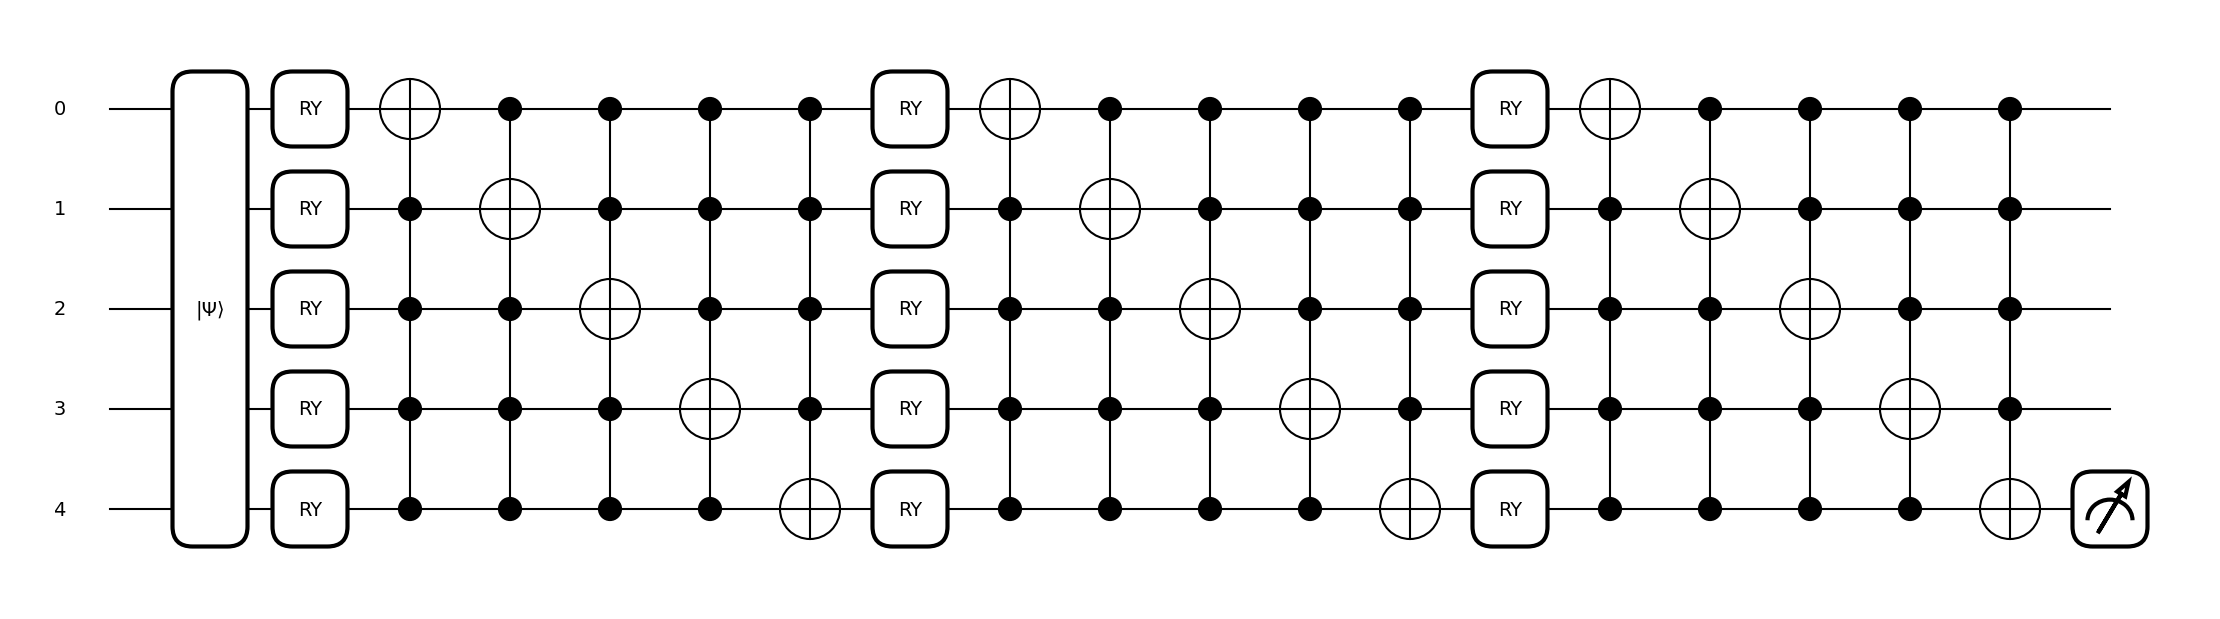

In [5]:
def decimalToBinary(n, dim):
    return "0"*(dim - len(bin(n).replace("0b", ""))) + bin(n).replace("0b", "")

def amp_state_prep(image):
    im_q = (1/4)*Statevector.from_label(decimalToBinary(0, 4)).tensor(Statevector([np.sqrt(1-image[0]), np.sqrt(image[0])]))
    for i in range(1,len(image)):
        im_q += (1/4)*Statevector.from_label(decimalToBinary(i, 4)).tensor(Statevector([np.sqrt(1-image[i]), np.sqrt(image[i])]))
    qml.QubitStateVector(np.array(im_q), wires=range(5))
    
def amp_ansatz(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.RY(weights[2], wires=wires[2])
    qml.RY(weights[3], wires=wires[3])
    qml.RY(weights[4], wires=wires[4])
    qml.MultiControlledX(wires=[1,2,3,4,0])
    qml.MultiControlledX(wires=[0,2,3,4,1])
    qml.MultiControlledX(wires=[1,0,3,4,2])
    qml.MultiControlledX(wires=[1,2,0,4,3])
    qml.MultiControlledX(wires=[1,2,3,0,4])
    
def amp_ansatz1(weights, wires):
    qml.RY(weights[0], wires=wires[0])
    qml.RY(weights[1], wires=wires[1])
    qml.RY(weights[2], wires=wires[2])
    qml.RY(weights[3], wires=wires[3])
    qml.RY(weights[4], wires=wires[4])
    qml.CRZ(weights[5], wires=[4,0])
    qml.CRZ(weights[6], wires=[0,1])
    qml.CRZ(weights[7], wires=[1,2])
    qml.CRZ(weights[8], wires=[2,3])
    qml.CRZ(weights[9], wires=[3,4])
    qml.MultiControlledX(wires=[1,2,3,0,4])

dev = qml.device("lightning.qubit", wires=5) # lightning for faster work

@qml.qnode(dev, interface="autograd")
def amp_circuit(image, weights):
    amp_state_prep(image)
    amp_ansatz(weights[:5], wires=[0,1,2,3,4])
    amp_ansatz(weights[5:], wires=[0,1,2,3,4])
    amp_ansatz(weights[10:], wires=[0,1,2,3,4])
    observable = qml.PauliZ(4)
    return qml.expval(observable)
    
np.random.seed(42)
weights = np.random.random(size=(15,1))
image_index = 1
fig, ax = qml.draw_mpl(amp_circuit, expansion_strategy=None)(images_train[image_index], weights)

In [6]:
def amp_objective(weights):
    obj = 0
    for i, image in enumerate(images_train):
        prediction = amp_circuit(image, weights)
        if labels_train[i] == -1:
            obj += prediction
        if labels_train[i] == 1:
            obj -= prediction
    return obj

In [8]:
np.random.seed(1)
amp_params = np.random.random(size=[15, 1], requires_grad=True)
optimizer = qml.GradientDescentOptimizer(stepsize=0.005)
start_time = time.time()
amp_err = []
amp_num_steps = 50
for k in range(amp_num_steps):
    step = optimizer.step_and_cost(amp_objective, amp_params)
    amp_err.append(step[1])
    if k % 1 == 0:
        print(f"Step {k}, cost: {step[1]}. Time passed: {round(time.time() - start_time, 2)}s")
    amp_params = step[0]
end_time = time.time()
print(f'{end_time-start_time}s')

Step 0, cost: 25.108346272641047. Time passed: 178.93s
Step 1, cost: -3.7482224438591745. Time passed: 357.68s
Step 2, cost: -59.886377996838384. Time passed: 534.4s
Step 3, cost: -129.32311350664887. Time passed: 710.04s
Step 4, cost: -155.9484730877695. Time passed: 885.49s
Step 5, cost: -166.4477244624864. Time passed: 1054.12s
Step 6, cost: -174.86392341335844. Time passed: 1222.81s
Step 7, cost: -182.15668636489565. Time passed: 1391.4s
Step 8, cost: -188.46349155488943. Time passed: 1560.38s
Step 9, cost: -193.88618010820682. Time passed: 1729.63s
Step 10, cost: -198.55200237506583. Time passed: 1900.19s
Step 11, cost: -202.59129963909385. Time passed: 2071.22s
Step 12, cost: -206.11786196387075. Time passed: 2242.21s
Step 13, cost: -209.22124050191067. Time passed: 2413.03s
Step 14, cost: -211.9660596044444. Time passed: 2584.1s
Step 15, cost: -214.3953115123218. Time passed: 2755.28s
Step 16, cost: -216.53658768633346. Time passed: 2926.4s
Step 17, cost: -218.40953181675448. Ti

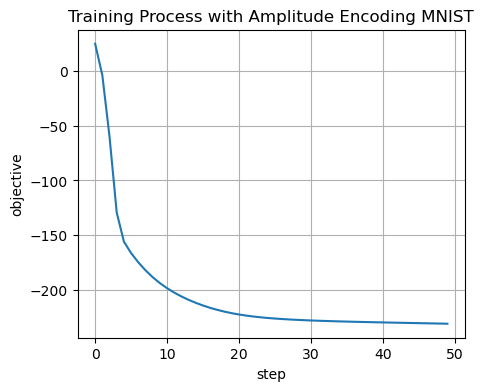

In [9]:
plt.plot(amp_err, '-')
plt.xlabel('step')
plt.ylabel('objective')
plt.title('Training Process with Amplitude Encoding MNIST')
plt.grid()

In [12]:
amp_performance_train = metrics(images_train, labels_train, amp_circuit, amp_params)
amp_performance_test = metrics(images_test, labels_test, amp_circuit, amp_params)
print(f"Accuracy, F1, Precision, Recall on training images: {[round(m, 3) for m in amp_performance_train]}")
print(f"Accuracy, F1, Precision, Recall on testing images:  {[round(m, 3) for m in amp_performance_test]}")

Accuracy, F1, Precision, Recall on training images: [0.899, 0.896, 0.926, 0.868]
Accuracy, F1, Precision, Recall on testing images:  [0.91, 0.905, 0.93, 0.882]


In [13]:
amp_performance_train_whole = metrics(images_train_whole, labels_train_whole, amp_circuit, amp_params)
print(f"Accuracy, F1, Precision, Recall on the whole training set: {[round(m, 3) for m in amp_performance_train_whole]}")

Accuracy, F1, Precision, Recall on the whole training set: [0.902, 0.896, 0.935, 0.861]
